# Transcriptional drift of Gene Ontology groupings (full transcriptome)

Tong Shu Li

Initial exploration of transcriptional drift of genes grouped by Gene Ontology annotations.

In [1]:
import operator
import pandas as pd
import sys

from functools import partial
from functools import reduce

In [2]:
%matplotlib inline

In [3]:
sys.path.append("..")

In [4]:
from src.load_gene_ont import load_go
from src.load_gene_ont import parse_go_defn

from src.plots import plot_drift
from src.plots import plot_p_val_heatmap

from src.stats import p_val_pairs

---

## Read the data (full transcriptome)

In [5]:
data = pd.read_csv("../data/worms_mianserin/mean_cpm_values.tsv", sep = '\t')

In [6]:
data.shape

(230028, 12)

In [7]:
data.head()

,wormbaseid,symbol,seqname,cpm_val,sample,day_add_drug,day_harvest_rna,drug_conc_uM,drug_given,log_cpm,ref_log_cpm,drift
0,WBGene00022521,ZC132.2,ZC132.2,0.000226,1,1,1,0,water,-8.393649,-8.393649,0.0
1,WBGene00019835,R02F2.6,R02F2.6,0.000228,1,1,1,0,water,-8.386604,-8.386604,0.0
2,WBGene00006011,srx-120,F49C5.2,0.000262,1,1,1,0,water,-8.247548,-8.247548,0.0
3,WBGene00022884,ZK1248.17,ZK1248.17,0.000275,1,1,1,0,water,-8.199831,-8.199831,0.0
4,WBGene00005435,srh-227,C35D6.2,0.000298,1,1,1,0,water,-8.116741,-8.116741,0.0


## Read the Gene Ontology data

In [8]:
floc = "../data/gene_ontology/gene_association.wb"
go_data = load_go(floc)

In [9]:
go_data.head()

,database_id,db_obj_symbol,qualifier,go_id,db_ref,evidence,with_from,aspect,db_obj_name,db_obj_syn,db_obj_type,taxon,date,assigned_by,annot_ext,gene_prod_id
0,WBGene00000001,aap-1,NaN,GO:0005623,WB_REF:WBPaper00005614|PMID:12393910,IDA,NaN,C,NaN,Y110A7A.10,gene,taxon:6239,20060302,WB,NaN,NaN
1,WBGene00000001,aap-1,NaN,GO:0005942,GO_REF:0000033,IBA,PANTHER:PTN000806614,C,NaN,Y110A7A.10,gene,taxon:6239,20150227,GO_Central,NaN,NaN
2,WBGene00000001,aap-1,NaN,GO:0005942,GO_REF:0000002,IEA,InterPro:IPR001720,C,NaN,Y110A7A.10,gene,taxon:6239,20150826,WB,NaN,NaN
3,WBGene00000001,aap-1,NaN,GO:0008286,WB_REF:WBPaper00005614|PMID:12393910,IMP,NaN,P,NaN,Y110A7A.10,gene,taxon:6239,20060302,WB,NaN,NaN
4,WBGene00000001,aap-1,NaN,GO:0008340,WB_REF:WBPaper00005614|PMID:12393910,IMP,NaN,P,NaN,Y110A7A.10,gene,taxon:6239,20060302,WB,NaN,NaN


### GO term definitions

In [10]:
go_defn = parse_go_defn("../data/gene_ontology/go.obo")

In [11]:
go_defn.head()

,go_id,go_name
0,GO:0000001,mitochondrion inheritance
1,GO:0000002,mitochondrial genome maintenance
2,GO:0000003,reproduction
3,GO:0000005,obsolete ribosomal chaperone activity
4,GO:0000006,high-affinity zinc uptake transmembrane transp...


In [12]:
go_data["go_id"].nunique()

5123

In [13]:
go_defn["go_id"].nunique()

44471

In [14]:
go_data["database_id"].nunique()

12524

In [15]:
len(set(data["wormbaseid"]) & set(go_data["database_id"]))

11624

---

## Group genes together by GO term

In [16]:
# save the gene names for each GO term
go_groups = {
    go_term: set(df["database_id"])
    for go_term, df in go_data.groupby("go_id")
}

In [17]:
def filter_go(go_terms, go_groups, dataframe):
    """Filters a dataframe down to genes belonging to the listed GO terms."""
    genes = reduce(operator.or_, (go_groups[term] for term in go_terms))
    
    temp = pd.DataFrame({"wormbaseid": list(genes)})
    return pd.merge(temp, dataframe, how = "inner", on = "wormbaseid")

---

# Hypothesis testing

In [18]:
info = pd.DataFrame(
    [(go_term, len(genes)) for go_term, genes in go_groups.items()],
    columns = ["go_id", "num_genes"]
)

info = pd.merge(info, go_defn, how = "inner", on = "go_id")

In [19]:
good_genes = set(data["wormbaseid"])

info["num_in_data"] = info.loc[:, "go_id"].map(
    lambda v: len(good_genes & go_groups[v])
)

info = info.sort_values("num_in_data", ascending = False).reset_index(drop = True)

In [20]:
info.head()

,go_id,num_genes,go_name,num_in_data
0,GO:0009792,3189,embryo development ending in birth or egg hatc...,3008
1,GO:0000003,2303,reproduction,2148
2,GO:0016021,2024,integral component of membrane,1956
3,GO:0002119,2022,nematode larval development,1913
4,GO:0016020,1877,membrane,1826


In [21]:
(info["num_genes"] == info["num_in_data"]).sum()

4703

In [22]:
(10 <= info["num_in_data"]).sum()

897

Around 900 GO terms in the worm dataset have more than 10 genes in our dataset. Since the drift only makes sense for a group of genes, we will need to filter out GO terms which have only a few genes annotated.

Also consider the ontology tree later..

In [23]:
poss = info.query("num_in_data >= 10")

In [24]:
poss.head()

,go_id,num_genes,go_name,num_in_data
0,GO:0009792,3189,embryo development ending in birth or egg hatc...,3008
1,GO:0000003,2303,reproduction,2148
2,GO:0016021,2024,integral component of membrane,1956
3,GO:0002119,2022,nematode larval development,1913
4,GO:0016020,1877,membrane,1826


---

## Significance checking function

In [25]:
def signif(go_term, df, go_groups, groupby, drift_col, conditions):
    """Check for significant drift.
    
    For a subset of genes specified by the GO term, calculates the
    p-values when grouped together by the groupby. Then checks that
    all p values of the condition pairs are below the significance
    threshold.
    
    Conditions = dict(key: direction)
    where key = pair of groups, direction = boolean of whether the variance
    of the left group is larger
    """
    res = filter_go([go_term], go_groups, df)
    
    p_vals = p_val_pairs(res, groupby, drift_col)
    
    threshold = 0.05
    for pair in conditions:
        assert pair in p_vals, "{} not in p-val pairs".format(pair)
        
    return all(
        p_vals[i][0] < threshold and p_vals[i][1] == direction
        for i, direction in conditions.items()
    )

## Drift in water

Drift in water on day 10 is greater than drift on day 3.

In [26]:
water = data.query("drug_given == 'water' & day_harvest_rna > 1")

water_310 = partial(
    signif, df = water, go_groups = go_groups, groupby = "day_harvest_rna",
    drift_col = "drift",
    conditions = {(3, 10): False}
)

In [27]:
poss["water_310"] = poss["go_id"].map(water_310)

/home/toby/Research/Projects/ageing/venv/lib64/python3.4/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [28]:
poss["water_310"].value_counts()

False    754
True     143
Name: water_310, dtype: int64

---

## Drift on day 10: reduced in mianserin compared to water

In [29]:
mian_10 = partial(
    signif,
    df = data.query("day_add_drug == 1 & drug_conc_uM in(0, 50)"),
    go_groups = go_groups, groupby = ["drug_given", "day_harvest_rna"],
    drift_col = "drift",
    conditions = {
        (('mianserin', 10), ('water', 10)): False
    }
)

In [30]:
poss["mian_water_10"] = poss["go_id"].map(mian_10)

/home/toby/Research/Projects/ageing/venv/lib64/python3.4/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [31]:
poss["mian_water_10"].value_counts()

False    718
True     179
Name: mian_water_10, dtype: int64

## Results

In [32]:
poss.groupby(["water_310", "mian_water_10"]).size()

water_310  mian_water_10
False      False            668
           True              86
True       False             50
           True              93
dtype: int64

In the full transcriptome, 93 GO terms (with >= 10 genes) had significant drift:
1. Greater drift on day 10 in water compared to day 3.
2. Smaller drift on day 10 in mianserin compared to water.

## Check results:

In [33]:
poss.query("water_310 & mian_water_10")

,go_id,num_genes,go_name,num_in_data,water_310,mian_water_10
0,GO:0009792,3189,embryo development ending in birth or egg hatc...,3008,True,True
1,GO:0000003,2303,reproduction,2148,True,True
2,GO:0016021,2024,integral component of membrane,1956,True,True
3,GO:0002119,2022,nematode larval development,1913,True,True
4,GO:0016020,1877,membrane,1826,True,True
5,GO:0005634,1607,nucleus,1581,True,True
6,GO:0005737,1412,cytoplasm,1401,True,True
7,GO:0040011,1427,locomotion,1344,True,True
8,GO:0046872,1357,metal ion binding,1333,True,True
9,GO:0008152,1114,metabolic process,1096,True,True


## Check out one example:

## Syntaxin binding (GO:0019905)

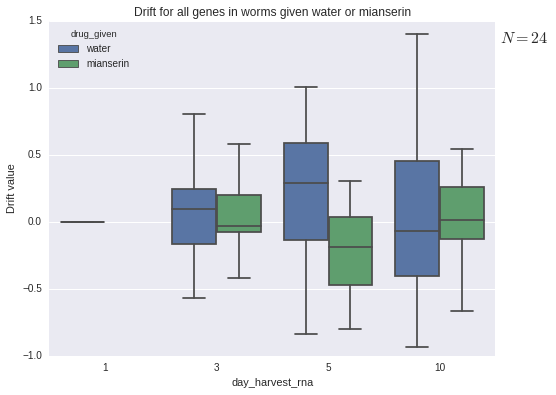

In [34]:
temp = data.query("day_add_drug == 1 & drug_conc_uM in(0, 50)")

term = "GO:0019905"

res = filter_go([term], go_groups, temp)
plot_drift(
    "box", res, "day_harvest_rna", "drift", "seqname",
    groupby = "drug_given", rc = {"figure.figsize": (8, 6)},
    title = "Drift for all genes in worms given water or mianserin"
)

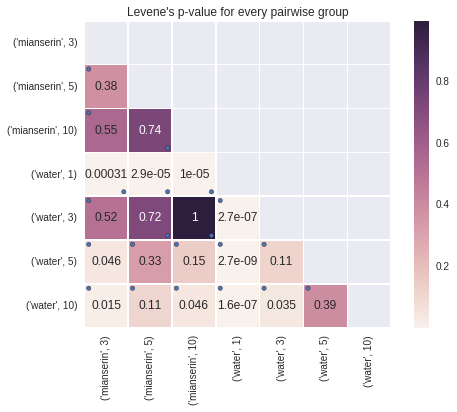

In [35]:
plot_p_val_heatmap(res, ["drug_given", "day_harvest_rna"], "drift", circles = True)

We see that for this GO term, the genes drifted apart in water as time went on, but that when given mianserin, the genes do not drift apart. They are lower than water, but do not drift apart compared to one another.